In [96]:
import deribit_data as dm
import pandas as pd
import numpy as np
import datetime
import json
import time
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression  
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error, r2_score

from IPython.display import clear_output

# Définitions de fonctions

Commençons par définir un certain nombre de fonctions utiles pour le traitement de la donnée, il sagit essentiellement de fonctions pour la conversion entre dates et timestamp

In [46]:
def somme_ponderee(X):
    """
    Input: str représentant une liste de listes de floats = '[[a1,b1],[a2,b2],...,[an,bn]]'
    Output: (Somme des ak*bk) / (Somme des bk)
    """
    s = 0
    d = 0
    
    for x in json.loads(X):

        if len(x)<2:
            return 0.0
        s += x[0]*x[1]
        d += x[1]
    if d!= 0:
        s/= d
    else:
        return 0.0
    return s

def string_to_dict(s):
    """
    Input: str représentant un dictionnaire
    Output: Le dit dictionnaire
    """
    json_acceptable_string = s.replace("'", "\"").replace("None","0.0")
    return json.loads(json_acceptable_string)

def to_date(ts):
    """
    Input: timestamp = nombre de secondes depuis le 01/01/1970
    Output: date
    """
    return str(datetime.datetime.fromtimestamp(ts))


def to_ts(date):
    """
    Input: Date, au format {dd/mm/yy, yy-mm-dd, 13DEC21}
    Output: timestamp en secondes
    """

    
    if '/' in date: #Format dd/mm/yy
        return int(time.mktime(datetime.datetime.strptime(date, "%d/%m/%Y").timetuple()))
    elif '-' in date: #Format yy-mm-dd
        return int(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()))
    else: # FORMAT 13DEC21
        if len(date)<7:
            date = '0'+date

            
        day = date[:2]
        year = date[-2:]
        month = date[2:-2]

        month_d = { 'JAN':'01',
                    'FEB':'02',
                    'MAR':'03',
                    'APR':'04',
                    'MAY':'05',
                    'JUN':'06',
                    'JUL':'07',
                    'AUG':'08',
                    'SEP':'09',
                    'OCT':'10',
                    'NOV':'11',
                    'DEC':'12'}


        return to_ts(day+'/'+month_d[month]+'/20'+year)
    
def ms_to_s(ts):
    """
    Input: timestamp en ms
    Outpu: timestamp en s
    """
    return int(ts/1000)

def ts_to_days(ts):
    """
    Input: timestamp en s
    Output: nombre de jours, float
    """
    return ts/(3600*24)


# Data processing
## 1 - Récupération de la data sur Deribit

In [47]:
#btc_data = dm.Options("BTC")
#btc_data.collect_data(save_csv=True)




## 2 - Data extraction

In [48]:
# Pre-loading downloaded data
btc_df = pd.read_csv("btc_options_data-2021_Jun_10-10_19_01.csv", index_col=0)
btc_df['mid_iv'] = (btc_df.bid_iv + btc_df.ask_iv)/2

btc_df['V'] = [x['volume'] for x in btc_df['stats'].apply(string_to_dict)]




Le plus simple est de définir une pipeline de traitement, pour avoir des DataFrames prêts à l'utilisation ensuite.

In [57]:
def pipeline(df):
    

    #### Ajout des Strikes K et des dates de maturité _T 
    EXP_DATES, STRIKES = [], []
    for inst_name in df['instrument_name']:
        el = inst_name.split('-')
        EXP_DATES.append(el[1])
        STRIKES.append(el[2])

    
    
    df = df.assign( _T = EXP_DATES)
    df = df.assign( K = STRIKES)
    
    #Equivalent a : 
    #df['K'] = STRIKES
    #df['_T'] = EXP_DATES
    
    

    
    
    #### Ajout des bids/asks/mid
    df['bids'] = df['bids'].apply(somme_ponderee)
    df['asks'] = df['asks'].apply(somme_ponderee)
    df['mid'] = (df.bids+df.asks)/2
    

    #### Supression des lignes ou les IV sont nulles et où les Volumes sont nuls
    df = df.drop(df[df.mid_iv == 0.0].index)
    df = df.drop(df[df.V == 0.0].index)
    
    #### Changement de _T pour le nombre de jours restants avant l'expiration du contrat (à partir du call de la fonction)
    df['_T'] = df['_T'].apply(to_ts) - datetime.datetime.timestamp(datetime.datetime.today())#btc_subset['timestamp'].apply(ms_to_s)
    df['_T'] = df['_T'].apply(ts_to_days)
    
    #### Ajout du prix du sous-jacent 
    df['S'] = df['underlying_price']
    
    #### Tri selon les Strikes croissants
    df = df.sort_values('K')



    final_df = df[['S','K','V', '_T', 'mid_iv','bids','asks','last_price','mid']]

    return final_df

#btc_data.head()
    

In [58]:
btc_call = pipeline(btc_df[btc_df.option_type == 'C'])
btc_put  = pipeline(btc_df[btc_df.option_type == 'P'])

btc_call = btc_call.astype(float)

In [67]:
btc_call.tail(200)

,S,K,V,_T,mid_iv,bids,asks,last_price,mid
400,38890.92,100000.0,0.6,287.454552,97.625,0.060794,0.098212,0.0950,0.079503
268,36895.86,100000.0,0.1,14.412886,88.965,0.000000,0.017171,0.0005,0.008586
336,37055.68,100000.0,2.0,49.412886,117.765,0.000805,0.009361,0.0025,0.005083
197,37591.02,100000.0,47.3,105.412886,102.235,0.005908,0.260719,0.0140,0.133314
385,38301.58,100000.0,55.1,203.454552,99.870,0.029876,0.193403,0.0530,0.111640
...,...,...,...,...,...,...,...,...,...
186,37321.87,80000.0,1.1,77.412886,97.335,0.008716,0.016342,0.0140,0.012529
48,36896.27,80000.0,13.0,14.412886,148.880,0.000500,0.013062,0.0005,0.006781
379,37590.07,88000.0,50.9,105.412886,99.005,0.009392,0.104991,0.0195,0.057191
345,37326.18,90000.0,28.0,77.412886,100.590,0.006607,0.013826,0.0070,0.010217


In [68]:
#btc_put.head()

In [69]:
#btc_call.to_csv("btc_call.csv")
#btc_put.to_csv("btc_put.csv")
#btc_call.to_excel("btc_call.xlsx")
#btc_put.to_excel("btc_put.xlsx")

# Plotting des fonctions

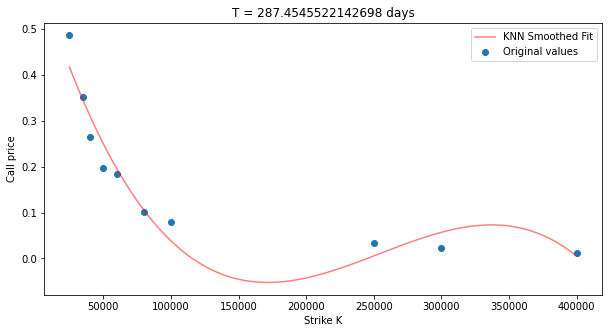

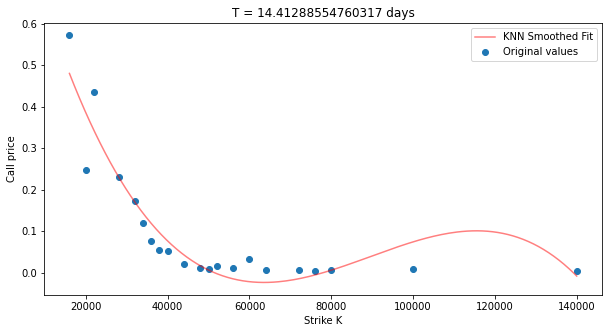

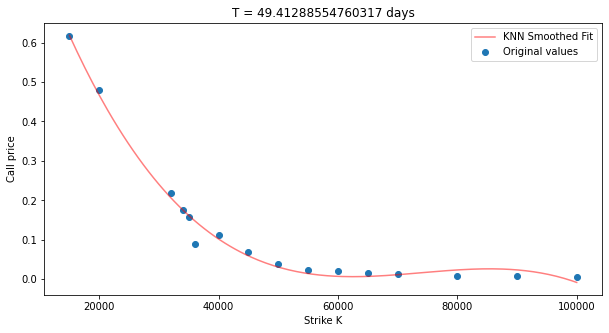

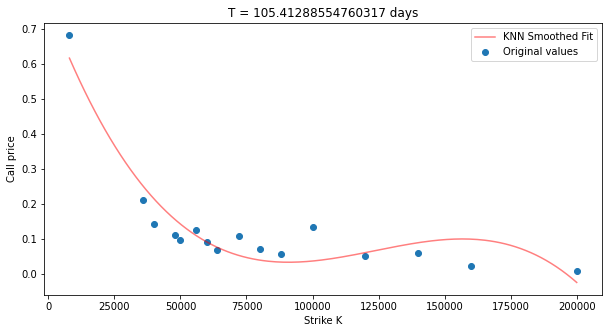

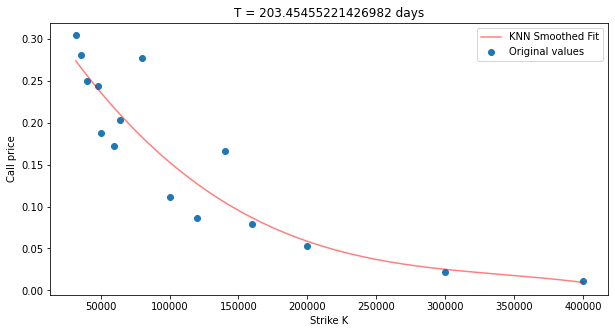

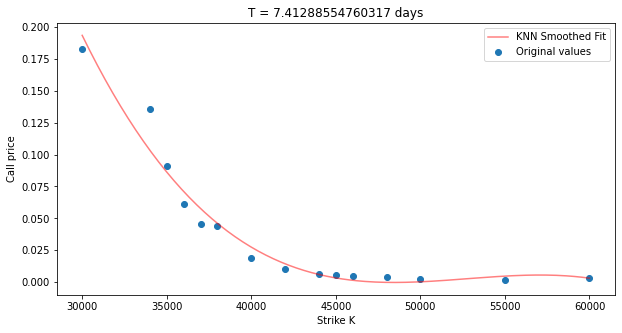

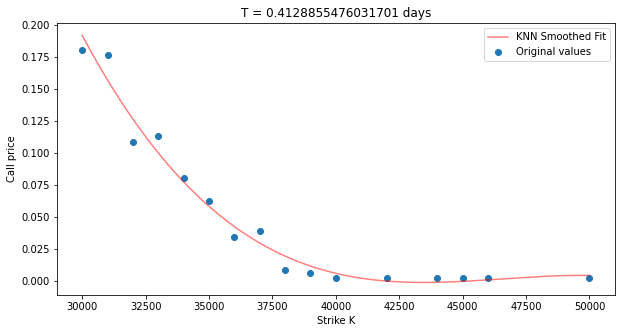

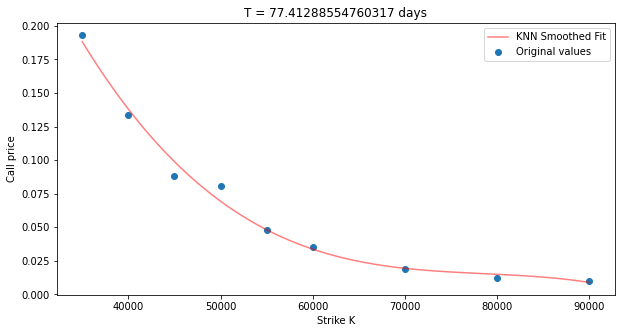

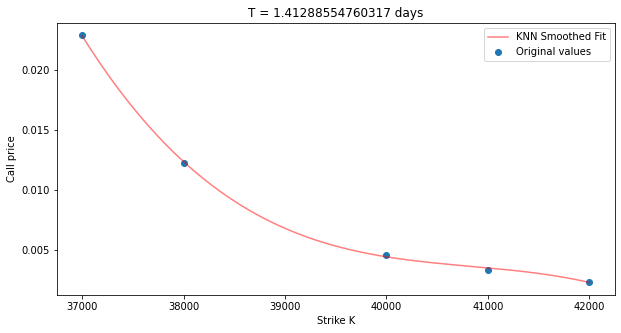

In [97]:
btc_data = btc_call

res = []
for i in list(btc_data['_T']):
    if i not in res:
        res.append(i)

plt.rcParams["figure.figsize"] = (10,5)

for T in res:
    
    X = btc_data[btc_data._T == T].K
    
    Y = btc_data[btc_data._T == T].mid
    

    plt.xlabel('Strike K')
    plt.ylabel('Call price')
    plt.title('T = {} days'.format(T))
    


    nb_degree = 3
    
    polynomial_features = PolynomialFeatures(degree = nb_degree)
    X_TRANSF = polynomial_features.fit_transform(X.values.reshape(-1,1))
    model = LinearRegression()
    model.fit(X_TRANSF, Y.values.reshape(-1,1))
    
    X_NEW = X.values.reshape(-1,1)
    
    X_NEW = np.linspace(min(list(X)), max(list(X)), num=int(200)).reshape(-1,1)
    
    X_NEW_TRANSF = polynomial_features.fit_transform(X_NEW)
    Y_NEW = model.predict(X_NEW_TRANSF)
    
    
    
    
    plt.plot(X_NEW, Y_NEW, c='r', alpha=0.50, label='KNN Smoothed Fit')
    plt.scatter(X, Y, label = "Original values") #label='Mid Implied Volatility')
    plt.legend()
    plt.show()


    


On observe un certain nombre de points aberrants, je suppose que cela vient de la trop faible liquidité pour ces contrats, nous allons donc faire un traitement pour exclure les rows trop peu liquides.

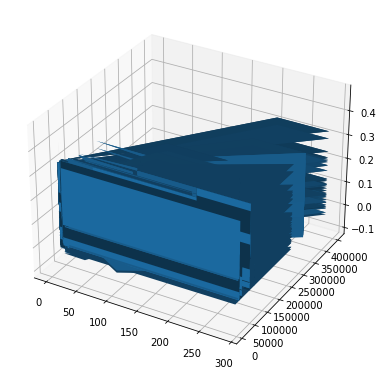

             _T         K
400  287.454552  100000.0
268   14.412886  100000.0
336   49.412886  100000.0
197  105.412886  100000.0
385  203.454552  100000.0
..          ...       ...
186   77.412886   80000.0
48    14.412886   80000.0
379  105.412886   88000.0
345   77.412886   90000.0
89    49.412886   90000.0

[123 rows x 2 columns]


In [163]:
# TEST AVEC LES DEUX VAR
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
axes = Axes3D(fig)

x = btc_data[['_T','K']].astype(float)
y = btc_data['mid'].astype(float) #ou last_price ?


regr = linear_model.LinearRegression()
regr.fit(x,y)

#print(x.head())
#axes.plot_surface(list(x['_T']),list(x['K']),y.values.reshape(-1,1))




nb_degree = 3
polynomial_features = PolynomialFeatures(degree = nb_degree)
X_TRANSF = polynomial_features.fit_transform(x)
model = LinearRegression()
model.fit(X_TRANSF, y.values.reshape(-1,1))

X_NEW = x
#X_NEW = np.linspace(min(list(X)), max(list(X)), num=int(200)).reshape(-1,1)

X_NEW_TRANSF = polynomial_features.fit_transform(X_NEW)
Y_NEW = model.predict(X_NEW_TRANSF)
axes.plot_surface(list(x['_T']),list(x['K']),Y_NEW)
plt.show()



"""
nb_degree = 3

polynomial_features = PolynomialFeatures(degree = nb_degree)
X_TRANSF = polynomial_features.fit_transform(X.values.reshape(-1,1))
model = LinearRegression()
model.fit(X_TRANSF, Y.values.reshape(-1,1))

X_NEW = X.values.reshape(-1,1)

X_NEW = np.linspace(min(list(X)), max(list(X)), num=int(200)).reshape(-1,1)

X_NEW_TRANSF = polynomial_features.fit_transform(X_NEW)
Y_NEW = model.predict(X_NEW_TRANSF)
"""


"""
plt.plot(X_NEW, Y_NEW, c='r', alpha=0.50, label='KNN Smoothed Fit')
plt.scatter(X, Y, label = "Original values") #label='Mid Implied Volatility')
plt.legend()
plt.show()
"""
print(x)

In [237]:
class Call:
    def __init__(self,model,df):
        self.model = model
        self.polynomial_features = PolynomialFeatures(degree = 3)
        print('S0 = ',list(df['S'])[0])
        
    def C(self,K,T):
        #x = pd.DataFrame(np.array([K],[T]), columns = ['K','_T'])

        d = { '_T': [T], 'K': [K]}
        x = pd.DataFrame(data=d)

        X_NEW = self.polynomial_features.fit_transform(x)
        
        return float(np.squeeze(self.model.predict(X_NEW)))
    
        

In [238]:
call = Call(model, btc_call)

S0 =  38890.92


In [239]:
btc_call.head(10)

,S,K,V,_T,mid_iv,bids,asks,last_price,mid
400,38890.92,100000.0,0.6,287.454552,97.625,0.060794,0.098212,0.0950,0.079503
268,36895.86,100000.0,0.1,14.412886,88.965,0.000000,0.017171,0.0005,0.008586
336,37055.68,100000.0,2.0,49.412886,117.765,0.000805,0.009361,0.0025,0.005083
197,37591.02,100000.0,47.3,105.412886,102.235,0.005908,0.260719,0.0140,0.133314
385,38301.58,100000.0,55.1,203.454552,99.870,0.029876,0.193403,0.0530,0.111640
164,37585.05,120000.0,83.4,105.412886,107.125,0.005263,0.097676,0.0085,0.051469
179,38315.69,120000.0,56.5,203.454552,101.145,0.025608,0.146228,0.0400,0.085918
157,36886.42,140000.0,10.0,14.412886,114.035,0.000000,0.009047,0.0005,0.004524
306,38305.96,140000.0,4.7,203.454552,104.240,0.019128,0.314846,0.0285,0.166987
362,37598.11,140000.0,208.8,105.412886,111.035,0.003025,0.118628,0.0065,0.060827


In [243]:
call.C(K = 120400.0,T = 413.454552 )

0.02676507682744428